<a target="_blank" href="https://colab.research.google.com/github/kurchi1205/ERA-S10-Assignment/blob/main/training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import os

# Define the repository and the target directory
repo_url = 'https://github.com/kurchi1205/ERA-S10-Assignment'
target_dir = '/content/era-s10'

# Check if the directory already exists
if not os.path.exists(target_dir):
    # If it doesn't exist, clone the repo
    !git clone {repo_url} {target_dir}
else:
    # If it exists, 'cd' into the directory and pull the latest changes
    %cd {target_dir}
    !git pull
    %cd ..

# Add the repository's directory to the system path
import sys
sys.path.append(target_dir)


In [8]:
!pip install torch-lr-finder

In [1]:
import torch
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2


from data import CIFAR10WithAlbumentations
from custom_resnet import Net
from utils_train import train, test

In [2]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=4, min_width=4, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

train_ds = CIFAR10WithAlbumentations('./data', train=True, download=True, transform=train_transforms)
test_ds = CIFAR10WithAlbumentations('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)


CUDA Available? True


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
              ReLU-6          [-1, 128, 32, 32]               0
       BatchNorm2d-7          [-1, 128, 32, 32]             256
           Dropout-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-02


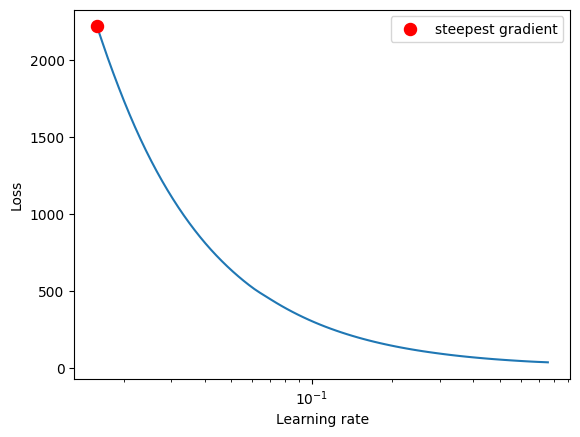

Axes(0.125,0.11;0.775x0.77)


In [5]:
from torch_lr_finder import LRFinder
import torch.nn.functional as F
import torch.nn as nn

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="exp")
lr = lr_finder.plot(log_lr=True, suggest_lr=True)
lr_finder.reset()
print(lr)

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [7]:
model =  Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
EPOCHS = 24
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.59E-02, epochs=EPOCHS, steps_per_epoch=98, anneal_strategy='cos',\
                                                div_factor=10, pct_start=0.2, three_phase=False)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch, train_losses, train_acc)
    test(model, device, test_loader, test_losses, test_acc)


EPOCH: 0


Loss=1.2624009847640991 Batch_id=97 Accuracy=43.09: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 1.5413, Accuracy: 4744/10000 (47.44%)

EPOCH: 1


Loss=1.0610814094543457 Batch_id=97 Accuracy=60.18: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 1.1617, Accuracy: 6102/10000 (61.02%)

EPOCH: 2


Loss=0.9067566394805908 Batch_id=97 Accuracy=66.67: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 1.0239, Accuracy: 6547/10000 (65.47%)

EPOCH: 3


Loss=0.9138667583465576 Batch_id=97 Accuracy=72.04: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.8683, Accuracy: 7142/10000 (71.42%)

EPOCH: 4


Loss=0.603179931640625 Batch_id=97 Accuracy=77.32: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s] 



Test set: Average loss: 0.6468, Accuracy: 7960/10000 (79.60%)

EPOCH: 5


Loss=0.4650086760520935 Batch_id=97 Accuracy=81.35: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s] 



Test set: Average loss: 0.5741, Accuracy: 8133/10000 (81.33%)

EPOCH: 6


Loss=0.4897218942642212 Batch_id=97 Accuracy=85.23: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s] 



Test set: Average loss: 0.5427, Accuracy: 8252/10000 (82.52%)

EPOCH: 7


Loss=0.4795949459075928 Batch_id=97 Accuracy=86.69: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s] 



Test set: Average loss: 0.4744, Accuracy: 8462/10000 (84.62%)

EPOCH: 8


Loss=0.2520061135292053 Batch_id=97 Accuracy=88.71: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s] 



Test set: Average loss: 0.4784, Accuracy: 8488/10000 (84.88%)

EPOCH: 9


Loss=0.41157686710357666 Batch_id=97 Accuracy=89.86: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.5040, Accuracy: 8481/10000 (84.81%)

EPOCH: 10


Loss=0.27399834990501404 Batch_id=97 Accuracy=91.36: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.4894, Accuracy: 8595/10000 (85.95%)

EPOCH: 11


Loss=0.3197133541107178 Batch_id=97 Accuracy=92.32: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s] 



Test set: Average loss: 0.4516, Accuracy: 8629/10000 (86.29%)

EPOCH: 12


Loss=0.22082212567329407 Batch_id=97 Accuracy=93.35: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.4474, Accuracy: 8664/10000 (86.64%)

EPOCH: 13


Loss=0.15870913863182068 Batch_id=97 Accuracy=94.38: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.4623, Accuracy: 8707/10000 (87.07%)

EPOCH: 14


Loss=0.12707440555095673 Batch_id=97 Accuracy=95.71: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.4487, Accuracy: 8779/10000 (87.79%)

EPOCH: 15


Loss=0.09277819097042084 Batch_id=97 Accuracy=96.49: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s] 



Test set: Average loss: 0.4197, Accuracy: 8901/10000 (89.01%)

EPOCH: 16


Loss=0.11728823930025101 Batch_id=97 Accuracy=97.45: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s] 



Test set: Average loss: 0.3968, Accuracy: 8939/10000 (89.39%)

EPOCH: 17


Loss=0.07648414373397827 Batch_id=97 Accuracy=98.06: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s] 



Test set: Average loss: 0.4164, Accuracy: 8928/10000 (89.28%)

EPOCH: 18


Loss=0.046023111790418625 Batch_id=97 Accuracy=98.46: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.3913, Accuracy: 9006/10000 (90.06%)

EPOCH: 19


Loss=0.03423108533024788 Batch_id=97 Accuracy=98.77: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s] 



Test set: Average loss: 0.3953, Accuracy: 8992/10000 (89.92%)

EPOCH: 20


Loss=0.017596611753106117 Batch_id=97 Accuracy=99.09: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.3989, Accuracy: 9021/10000 (90.21%)

EPOCH: 21


Loss=0.0090219397097826 Batch_id=97 Accuracy=99.23: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]  



Test set: Average loss: 0.3912, Accuracy: 9027/10000 (90.27%)

EPOCH: 22


Loss=0.02878434583544731 Batch_id=97 Accuracy=99.20: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s] 



Test set: Average loss: 0.3964, Accuracy: 9029/10000 (90.29%)

EPOCH: 23


Loss=0.023790208622813225 Batch_id=97 Accuracy=99.30: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.3937, Accuracy: 9029/10000 (90.29%)

